In [4]:
from datasets.dataset_engine import RLBenchDataset
from utils.common_utils import (
    load_instructions, get_gripper_loc_bounds
)
from argparse import Namespace


args = {
    "dataset": "/home/share/3D_attn_felix/peract/Peract_packaged_normals/train",
    "tasks": "reach_and_drag",
    "valset": "/home/share/3D_attn_felix/peract/Peract_packaged_normals/val",
    "instructions": "/home/share/3D_attn_felix/peract//instructions.pkl",
    "use_instruction": 1,
    "rotation_parametrization": "6D",
    "gripper_loc_bounds": "/home/stud_herrmann/3d_diffuser_actor/tasks/18_peract_tasks_location_bounds.json",
    "num_workers": 1,
    "train_iters": 200000,
    "embedding_dim": 120,
    "diffusion_timesteps": 100,
    "val_freq": 1000,
    "dense_interpolation": 1,
    "interpolation_length": 2,
    "exp_log_dir": "2025.02.21/12.15.03_NURSA",
    "base_log_dir": "train_logs",
    "batch_size": 1,
    "batch_size_val": 1,
    "cache_size": 10000,
    "keypose_only": 1,  
    "variations": list(range(200)),
    "lr": 1e-4,
    "num_history": 3,
    "cameras": ["left_shoulder", "right_shoulder", "wrist", "front"],
    "max_episodes_per_task": -1,
    "quaternion_format": "xyzw",
    "fps_subsampling_factor": 5,
    "rot_noise": 0.0,
    "pos_noise": 0.0,
    "pcd_noise": 0.0,
    "image_rescale": "1.0,1.0",
    "image_size": "128,128",
    "max_episode_length": 5,
    "num_val_episodes": 5,
    "val_batch_size": 1,
    "val_num_workers": 1,
    "val_cache_size": 0
}

args = Namespace(**args)

def get_datasets(args):
    """Initialize datasets."""
    # Load instruction, based on which we load tasks/variations
    instruction = load_instructions(
        args.instructions,
        tasks=args.tasks,
        variations=args.variations
    )
    if instruction is None:
        raise NotImplementedError()
    else:
        taskvar = [
            (task, var)
            for task, var_instr in instruction.items()
            for var in var_instr.keys()
        ]

    # Initialize datasets with arguments
    train_dataset = RLBenchDataset(
        root=args.dataset,
        instructions=instruction,
        taskvar=taskvar,
        max_episode_length=args.max_episode_length,
        cache_size=args.cache_size,
        max_episodes_per_task=args.max_episodes_per_task,
        num_iters=args.train_iters,
        cameras=args.cameras,
        training=True,
        image_rescale=tuple(
            float(x) for x in args.image_rescale.split(",")
        ),
        return_low_lvl_trajectory=True,
        dense_interpolation=bool(args.dense_interpolation),
        interpolation_length=args.interpolation_length,
        rot_noise=args.rot_noise,
        pos_noise=args.pos_noise,
        pcd_noise=args.pcd_noise,
    )
    return train_dataset

train_dataset = get_datasets(args)

Can't find dataset folder /home/share/3D_attn_felix/peract/Peract_packaged_normals/train/reach_and_drag+10
Created dataset from /home/share/3D_attn_felix/peract/Peract_packaged_normals/train with 93


In [5]:
import torch

def traj_collate_fn(batch):
    keys = [
        "trajectory", "trajectory_mask",
        "rgbs", "pcds",
        "curr_gripper", "curr_gripper_history", "action", "instr"
    ]
    ret_dict = {
        key: torch.cat([
            item[key].float() if key != 'trajectory_mask' else item[key]
            for item in batch
        ]) for key in keys
    }

    ret_dict["task"] = []
    for item in batch:
        ret_dict["task"] += item['task']
    return ret_dict

import torch

def crop_and_resample_batch(points, min_bound, max_bound, max_points):
    """
    Crop point clouds to a 3D workspace and resample to a fixed size.
    
    Args:
        points (torch.Tensor): Input batch of point clouds. Shape: (B, N, 3)
        min_bound (torch.Tensor): Minimum bounds of workspace. Shape: (3,)
        max_bound (torch.Tensor): Maximum bounds of workspace. Shape: (3,)
        max_points (int): Target number of points per cloud after processing
    
    Returns:
        torch.Tensor: Processed point clouds with shape (B, max_points, 3)
    """
    device = points.device
    B, N, _ = points.shape
    
    # Create mask for points within workspace
    mask = (points >= min_bound) & (points <= max_bound)
    mask = mask.all(dim=-1)  # (B, N)
    
    processed_batch = []
    
    for i in range(B):
        # Extract valid points for this cloud
        valid_points = points[i][mask[i]]  # (K, 3)
        K = valid_points.size(0)
        
        if K == 0:
            raise ValueError(f"All points filtered in cloud {i}. Consider checking bounds or input data.")
        
        # Generate sampling indices
        if K >= max_points:
            # Randomly select subset without replacement
            indices = torch.randperm(K, device=device)[:max_points]
        else:
            # Sample with replacement to reach max_points
            indices = torch.randint(0, K, (max_points,), device=device)
        
        # Select points and maintain gradient flow
        sampled_points = valid_points[indices]
        processed_batch.append(sampled_points)
    
    return torch.stack(processed_batch, dim=0)

In [6]:
import torch


data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True,
    collate_fn=traj_collate_fn,
)


In [7]:
batch = next(iter(data_loader))

def normalize_pos(pos, gripper_loc_bounds):
    pos_min = gripper_loc_bounds[0].float().to(pos.device)
    pos_max = gripper_loc_bounds[1].float().to(pos.device)
    return (pos - pos_min) / (pos_max - pos_min) * 2.0 - 1.0


gripper_location_bounds = torch.from_numpy(get_gripper_loc_bounds(args.gripper_loc_bounds))


Gripper workspace size: [0.67823578 0.99414986 0.71873248]


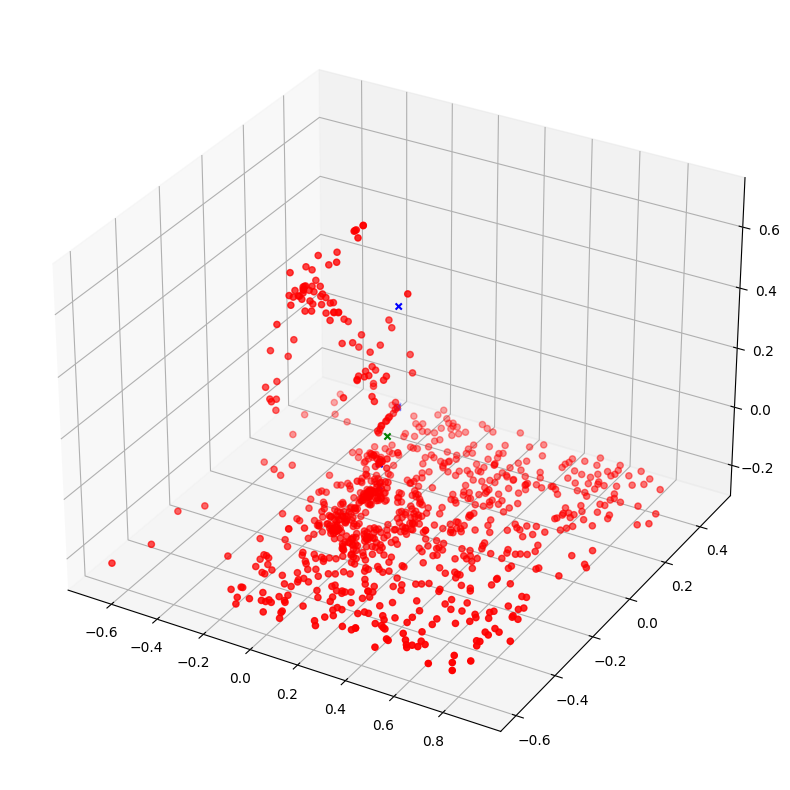

In [8]:
from utils.common_utils import (
    get_gripper_loc_bounds
)
import numpy as np
import matplotlib.pyplot as plt


# get pcd and action
pcd = batch['pcds'].clone().permute(0, 1, 3, 4, 2).reshape(-1, 3)
action = batch['trajectory'].clone()[..., :3].reshape(-1, 3)

# center pcd and action
c = action.mean(dim=0)
pcd -= c
action -= c

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# randomly sample 1000 points
view_pcd = pcd[torch.randperm(pcd.shape[0])[:1000]]
view_pcd = view_pcd[np.linalg.norm(view_pcd, axis=1) < 1.0]
view_pcd = view_pcd.cpu().numpy()

action = action.cpu().numpy()
ax.scatter(view_pcd[:, 0], view_pcd[:, 1], view_pcd[:, 2], c='r', marker='o')
ax.scatter(action[:, 0], action[:, 1], action[:, 2], c='b', marker='x')
ax.scatter(0, 0, 0, c='g', marker='x')
plt.show()

min_workspace = torch.from_numpy(view_pcd.min(axis=0)) + c
max_workspace = torch.from_numpy(view_pcd.max(axis=0)) + c
mean_workspace = (min_workspace + max_workspace) / 2
workspace_size = max_workspace - min_workspace
max_points = view_pcd.shape[0]


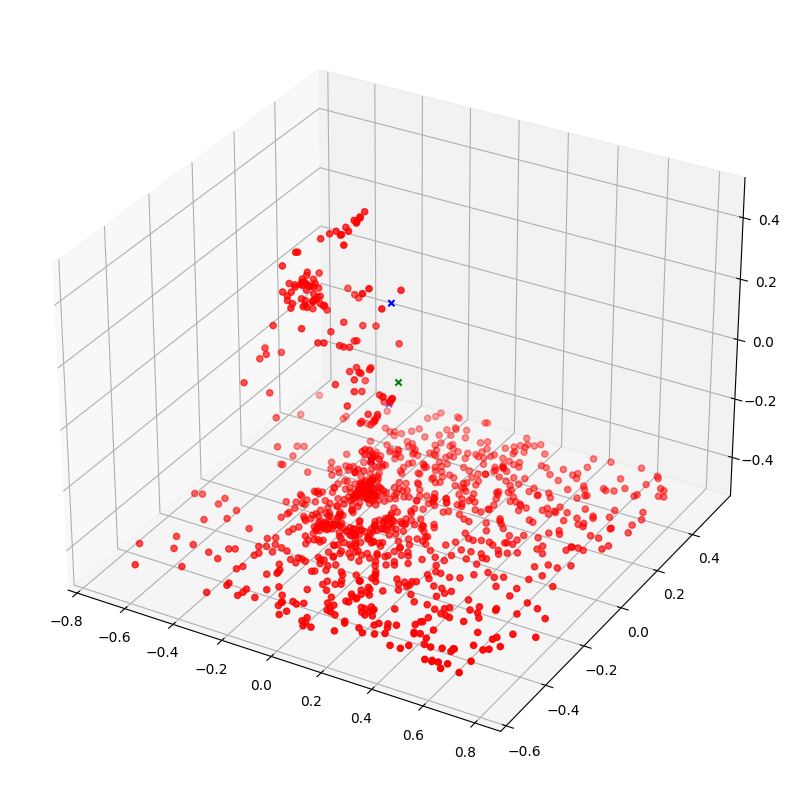

In [9]:
# get pcd and action
pcd = batch['pcds'].clone().permute(0, 1, 3, 4, 2).reshape(-1, 3)
action = batch['trajectory'].clone()[..., :3].reshape(-1, 3)

pcd = pcd.reshape(4, -1, 3)
# crop and resample pcd
pcd = crop_and_resample_batch(
    pcd, min_workspace, max_workspace, max_points
)
pcd = pcd.reshape(-1, 3)

# center pcd and action
pcd -= mean_workspace
action -= mean_workspace

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# randomly sample 1000 points
view_pcd = pcd[torch.randperm(pcd.shape[0])[:1000]]
view_pcd = view_pcd[np.linalg.norm(view_pcd, axis=1) < 1.0]
view_pcd = view_pcd.cpu().numpy()
action = action.cpu().numpy()
ax.scatter(view_pcd[:, 0], view_pcd[:, 1], view_pcd[:, 2], c='r', marker='o')
ax.scatter(action[:, 0], action[:, 1], action[:, 2], c='b', marker='x')
ax.scatter(0, 0, 0, c='g', marker='x')
plt.show()




In [10]:
print(min_workspace, max_workspace, mean_workspace, workspace_size, max_points)

tensor([-0.4981, -0.5462,  0.7499]) tensor([1.0936, 0.5511, 1.6794]) tensor([0.2977, 0.0024, 1.2146]) tensor([1.5917, 1.0973, 0.9295]) 881
